## Loading the Data

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import time
import seaborn as sns
import boto3
import sagemaker
import sagemaker.amazon.common as smac

from scipy.sparse import csr_matrix, hstack, save_npz, load_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd 
import time

### Metadata

In [4]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_All_Beauty.json.gz

--2022-07-22 03:41:25--  http://deepyeti.ucsd.edu/jianmo/amazon/sample/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-07-22 03:41:25 ERROR 404: Not Found.



In [97]:
data = []
with gzip.open('meta_All_Beauty.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

32892
{'category': [], 'tech1': '', 'description': ["Loud 'N Clear Personal Sound Amplifier allows you to turn up the volume on what people around you are saying, listen at the level you want without disturbing others, hear a pin drop from across the room."], 'fit': '', 'title': "Loud 'N Clear&trade; Personal Sound Amplifier", 'also_buy': [], 'tech2': '', 'brand': 'idea village', 'feature': [], 'rank': '2,938,573 in Beauty & Personal Care (', 'also_view': [], 'details': {'ASIN: ': '6546546450'}, 'main_cat': 'All Beauty', 'similar_item': '', 'date': '', 'price': '', 'asin': '6546546450', 'imageURL': [], 'imageURLHighRes': []}


In [74]:
df = pd.DataFrame.from_dict(data)

print(len(df))

32892


In [75]:

df3 = df.fillna('')
df4 = df3[df3.title.str.contains('getTime')] # unformatted rows
df5 = df3[~df3.title.str.contains('getTime')] # filter those unformatted rows
print(len(df4))
print(len(df5))

0
32892


In [85]:
# how those unformatted rows look like
df5.head(5)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [8]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/sample/All_Beauty.json.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
data2 = []
with gzip.open('All_Beauty.json.gz') as f:
    for l in f:
        data2.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data2))

# first row of the list
print(data2[0])

FileNotFoundError: [Errno 2] No such file or directory: 'All_Beauty.json.gz'

### Ratings Dataset

In [8]:
ratings = pd.read_csv('ratings_beauty3.csv')

In [9]:
ratings.head(5)

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,205616461,5,1369699200
1,A3JM6GV9MNOF9X,558925278,3,1355443200
2,A1Z513UWSAAO0F,558925278,5,1404691200
3,A1WMRR494NWEWV,733001998,4,1382572800
4,A3IAAVS479H7M7,737104473,1,1274227200


In [10]:
ratings.describe()

,Rating,Timestamp
count,238228.000000,2.382280e+05
mean,4.181053,1.333672e+09
std,1.322361,7.117489e+07
min,1.000000,9.087552e+08
25%,4.000000,1.305396e+09
50%,5.000000,1.360454e+09
75%,5.000000,1.384646e+09
max,5.000000,1.406074e+09


In [6]:
ratings.isnull().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

In [13]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.catplot("Rating", data=ratings, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")



## Model-based collaborative filtering system


In [14]:
df=ratings.head(10000)
matrix = df.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
matrix.head()

ProductId,1304139212,1304139220,130414089X,130414643X,1304146537,130414674X,1304168522,1304174778,1304174867,1304174905,...,B000052YPE,B000052YPF,B000052YPG,B000052YPH,B000052YPM,B000052YPU,B000052YPV,B000052YPY,B000052YQ0,B000052YQ2
UserId,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A024581134CV80ZBLIZTZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03056581JJIOL5FSKJY7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03099101ZRK4K607JVHH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0505229A7NSH3FRXRR4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
matrix.shape


(9697, 886)

In [16]:
X = matrix.T
X.head()

UserId,A00205921JHJK5X9LNP42,A024581134CV80ZBLIZTZ,A03056581JJIOL5FSKJY7,A03099101ZRK4K607JVHH,A0505229A7NSH3FRXRR4,A05492663T95KW63BR75K,A059547920Q3LZVFHLPI3,A07410232KYRFR25CIUGJ,A082796624UNM47DSAI6K,A0864963DOAY7LXGS5I6,...,AZW1HXXYAC15B,AZWRTJPN7NXT,AZWTXHXZXFAYP,AZYQEFB9Y5N22,AZZHB6U54UDYW,AZZHJZP4GQPPZ,AZZNK89PXD006,AZZOFVMQC0BJG,AZZQXL8VDCFTV,AZZTJQ7CQZUD8
ProductId,,,,,,,,,,,,,,,,,,,,,
1304139212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1304139220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130414089X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130414643X,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1304146537,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(886, 10)

In [63]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(886, 886)

In [64]:
X.index[311]


'9790773161'

In [65]:
i = "9790773161"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

311

In [66]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(886,)

In [82]:
Recommend = list(X.index[correlation_product_ID > 0.90])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:9]

['9788072208',
 '9788077927',
 '9790770839',
 '9790770898',
 '9790774443',
 '9790779399',
 '9790789831',
 'B00000JGVY',
 'B00004TZYD']

## Popularity Based System

This recommendation system would be ideal for new customers.

In [6]:
newdf=ratings.groupby("ProductId").filter(lambda x:x['Rating'].count() >=50)

NameError: name 'ratings' is not defined

In [104]:
ratings_perproduct = newdf.groupby(by='ProductId')['Rating'].count().sort_values(ascending=False)


In [105]:
newdf.groupby('ProductId')['Rating'].mean().head()


ProductId
9790790961    4.271429
9790799829    2.640000
B00004TMFE    3.445255
B00004TUBL    4.634409
B00004TUBV    4.269006
Name: Rating, dtype: float64

<AxesSubplot:xlabel='ProductId'>

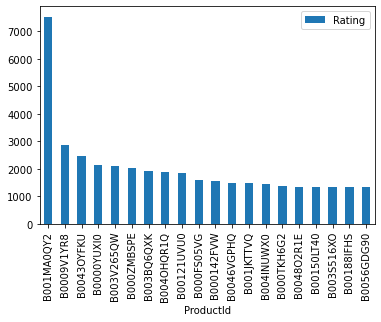

In [107]:
popular_products = pd.DataFrame(newdf.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(20).plot(kind = "bar")


## Factor Matrixization

A sparse matrix is needed for the Factor Matrization method. There needs to be one-hot encoding on customer_id and product_id

In [11]:
ratings.drop(['Timestamp'], axis=1, inplace=True)


In [12]:
ratings

,UserId,ProductId,Rating
0,A39HTATAQ9V7YF,205616461,5
1,A3JM6GV9MNOF9X,558925278,3
2,A1Z513UWSAAO0F,558925278,5
3,A1WMRR494NWEWV,733001998,4
4,A3IAAVS479H7M7,737104473,1
...,...,...,...
238223,A1F1CLG22Z98BY,B000F4GINO,5
238224,ABNARV2XL4GL7,B000F4GINO,5
238225,A2RQFD8Y8F72TV,B000F4GINO,3
238226,A1U70HGMKIDBJV,B000F4GINO,5


In [13]:
ratings.drop_duplicates(['UserId', 'ProductId'], inplace=True)

In [14]:
ohe = OneHotEncoder(handle_unknown = "ignore")
ohe_cols = ["UserId", "ProductId"]
ohe_features = ohe.fit_transform(ratings[ohe_cols])
ohe_features


<238228x224116 sparse matrix of type '<class 'numpy.float64'>'
	with 476456 stored elements in Compressed Sparse Row format>

In [15]:
ohe_features

<238228x224116 sparse matrix of type '<class 'numpy.float64'>'
	with 476456 stored elements in Compressed Sparse Row format>

In [16]:
ratings.head(5)

,UserId,ProductId,Rating
0,A39HTATAQ9V7YF,205616461,5
1,A3JM6GV9MNOF9X,558925278,3
2,A1Z513UWSAAO0F,558925278,5
3,A1WMRR494NWEWV,733001998,4
4,A3IAAVS479H7M7,737104473,1


In [15]:
ohe_feature_names = ohe.get_feature_names()
df_ohe = pd.DataFrame(data = ohe_features.toarray(), index=range(len(ratings)), columns=ohe_feature_names)

In [16]:
#y is the target label needed for the task
y = ratings["Rating"].values.astype("float32")
y

array([5., 3., 5., ..., 3., 5., 5.], dtype=float32)

In [17]:
X = hstack([ohe_features], format="csr", dtype="float32")


In [20]:
total = X.shape[0] * X.shape[1]
non_zero = X.nnz
sparsity = (total - non_zero) / total

print("Total elements:", total)
print("Non-zero elements:", non_zero)
print("Sparsity:", round(sparsity*100, 4), "%")

Total elements: 53390706448
Non-zero elements: 476456
Sparsity: 99.9991 %


In [18]:
df_ohe

,x0_A00144702V3Q8N2EJ3S2G,x0_A00161083VTAXZ0YOD8GL,x0_A00205921JHJK5X9LNP42,x0_A00222842T0ZYI86C9LHU,x0_A00275441WYR3489IKNAB,x0_A00295401U6S2UG3RAQSZ,x0_A0038640S18JE5Y497U6,x0_A004205218STRNUW6PPPA,x0_A00473363TJ8YSZ3YAGG9,x0_A00507042PSBBTBJBSHDA,...,x1_B000F4EPM0,x1_B000F4EPMK,x1_B000F4EPNE,x1_B000F4EPP2,x1_B000F4EPS4,x1_B000F4GIMA,x1_B000F4GIMK,x1_B000F4GIMU,x1_B000F4GIN4,x1_B000F4GINO
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
238224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
238225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
238226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Split data into Training and Test set

An 80-20 split is done so that data can be split into training and test sets. 

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=73)           

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape, "\n")
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (190582, 224116)
Shape of y_train: (190582,) 

Shape of X_test: (47646, 224116)
Shape of y_test: (47646,)


## Saving test and train data

In [20]:
# Save the dataframe to csv.
ratings.to_csv("fm_preprocessed.csv", index=False)

# save_npz: Save a sparse matrix for X_train and X_test to a file using .npz format.
# np.savez: Save array for y_test into a single file in uncompressed .npz format.
save_npz("X_train.npz", X_train) 
save_npz("X_test.npz", X_test)
np.savez("y_train.npz", y_train) 
np.savez("y_test.npz", y_test)

# Save the feature dimension to a text file.
feature_dim = X.shape[1]
with open("feature_dim.txt", "w") as f:
    f.write(str(feature_dim))

## Packages to load for training

In [21]:
import numpy as np 
import pandas as pd 
import time

import boto3
import sagemaker
import sagemaker.amazon.common as smac

from scipy.sparse import csr_matrix, hstack, save_npz, load_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [22]:
# load array and sparse matrices.

X_train = load_npz("X_train.npz")
X_test = load_npz("X_test.npz")

y_train = np.load("y_train.npz")
y_test = np.load("y_test.npz")
y_train = y_train.f.arr_0
y_test = y_test.f.arr_0

# Example of sparse matrix for X_test
# pd.DataFrame(X_test.todense())


In [23]:
feature_dim = 0

# Read the saved feature dimension.
with open("feature_dim.txt", "r") as f:
    feature_dim = int(f.read())
    
feature_dim

224116

### Converting the data into recordIO-protobuf

The Factorization Machine algorithm only supports the recordIO-protobuf format with float 32. Therefore, the data needs to be converted to S3 protobuf

In [24]:
# Function to create sparse RecordIO file.

def write_sparse_recordio_file (filename, X, y=None):
    with open(filename, 'wb') as f:
        smac.write_spmatrix_to_sparse_tensor (f, X, y)

In [25]:
# Function to upload file to S3.
# https://boto3.amazonaws.com/v1/documentation/api/latest/guide/s3-uploading-files.html
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html#S3.Client.upload_fileobj

def upload_to_s3(filename, bucket, prefix, key):
    with open(filename,'rb') as f: # Read in binary mode
        boto3.Session().resource('s3').Bucket(bucket).Object(f"{prefix}/{key}").upload_fileobj(f)
        return f"s3://{bucket}/{prefix}/{key}"

In [26]:
# Creating the train and test RecordIO files.

write_sparse_recordio_file("fm_train.recordio", X_train, y_train)
write_sparse_recordio_file("fm_test.recordio", X_test, y_test)

In [27]:
# Uploading the train and test RecordIO files to S3.

sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()

prefix = "fm"
train_key = "fm_train.recordio"
test_key = "fm_test.recordio"
output_location = f"s3://{bucket}/{prefix}/output"

train_file_location = upload_to_s3("fm_train.recordio", bucket, prefix, train_key)
test_file_location = upload_to_s3("fm_test.recordio", bucket, prefix, test_key)

print("SageMaker version:", sagemaker.__version__)
print("Region:", region)
print("Bucket:", bucket)
print("train file location:", train_file_location)
print("test file location:", test_file_location)
print("model output location:", output_location)

SageMaker version: 2.99.0
Region: us-east-1
Bucket: sagemaker-us-east-1-942306542108
train file location: s3://sagemaker-us-east-1-942306542108/fm/fm_train.recordio
test file location: s3://sagemaker-us-east-1-942306542108/fm/fm_test.recordio
model output location: s3://sagemaker-us-east-1-942306542108/fm/output


## Training job and tuning hyperparameters

In [28]:
job_name = 'fm-job-v5'
job_name

'fm-job-v5'

In [29]:
# https://github.com/aws-samples/amazon-sagemaker-managed-spot-training/blob/main/xgboost_built_in_managed_spot_training_checkpointing/xgboost_built_in_managed_spot_training_checkpointing.ipynb
    
use_spot_instances = False
max_run = 3600                                   # set to 60 mins
max_wait = 3600 if use_spot_instances else None  # set to 60 mins (must be equal or greater than max_run)
   
checkpoint_s3_uri = (f"s3://{bucket}/{prefix}/checkpoints/{job_name}" if use_spot_instances
                     else None)
    
print(f"Checkpoint uri: {checkpoint_s3_uri}")

Checkpoint uri: None


In [30]:
role = sagemaker.get_execution_role()
role

'arn:aws:iam::942306542108:role/service-role/AmazonSageMaker-ExecutionRole-20220622T113338'

In [31]:
container = sagemaker.image_uris.retrieve("factorization-machines", region=region)
container

'382416733822.dkr.ecr.us-east-1.amazonaws.com/factorization-machines:1'

In [32]:
estimator = sagemaker.estimator.Estimator(    
    container,
    role,
    instance_count = 1,
    instance_type = "ml.m4.xlarge",   # Or "ml.c5.xlarge",
    output_path = output_location,
    sagemaker_session = sess,
    base_job_name = job_name,
    use_spot_instances = use_spot_instances,
    max_run = max_run,
    max_wait = max_wait,
    checkpoint_s3_uri = checkpoint_s3_uri
)

In [33]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/fact-machines-hyperparameters.html

estimator.set_hyperparameters(
    feature_dim = feature_dim,
    num_factors = 64,  
    predictor_type = "regressor",
    epochs = 83,      
    mini_batch_size = 1000,  
)

estimator.hyperparameters()

{'feature_dim': 224116,
 'num_factors': 64,
 'predictor_type': 'regressor',
 'epochs': 83,
 'mini_batch_size': 1000}

## Training the model

In [34]:
estimator.fit({'train':train_file_location, 
               'test':test_file_location})

2022-07-29 07:25:17 Starting - Starting the training job...
2022-07-29 07:25:44 Starting - Preparing the instances for trainingProfilerReport-1659079517: InProgress
.........
2022-07-29 07:27:01 Downloading - Downloading input data...
2022-07-29 07:27:42 Training - Downloading the training image......
2022-07-29 07:28:42 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:87: DeprecationWarning: invalid escape sequence \s
  """
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:120: DeprecationWarning: invalid escape

In [42]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer
import json

class fm_json_serializer(JSONSerializer):
    def serialize(self, data):
        js = {"instances": []}
        for row in data:
            js["instances"].append({"features": row.tolist()})
        return json.dumps(js)

In [3]:
predictor = estimator.deploy(initial_instance_count = 1,
                             instance_type = "ml.m5.xlarge",
                             endpoint_name = job_name,
                             serializer = fm_json_serializer(),
                             deserializer = JSONDeserializer(),
                            )

NameError: name 'estimator' is not defined

In [45]:
trending = ratings.copy()
trending = (trending.groupby(["ProductId"])
            .nunique()["UserId"]
            .sort_values(ascending=False)
            .reset_index()            
           )            
trending = trending.rename(columns={'customer_id': 'unique_customers'})
trending

,ProductId,UserId
0,B0009V1YR8,2869
1,B0000YUXI0,2143
2,B000142FVW,1558
3,B00021DVCQ,1051
4,B0002JKPA4,1046
...,...,...
16334,B0006Q05XU,1
16335,B0006Q05NK,1
16336,B0006Q041S,1
16337,B0006Q03VE,1


In [1]:
result = predictor.predict(X.toarray())
result

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-9f75955ba987>", line 1, in <module>
    result = predictor.predict(X.toarray())
NameError: name 'predictor' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/opt/conda/lib/python3.7/site-packages/IPyth

TypeError: object of type 'NoneType' has no len()

In [ ]:
products = ohe.inverse_transform(ohe_features)[:, 1]
products

In [ ]:
top_3_recommended = np.take_along_axis(products, index_array, axis=0)[: -3 - 1 : -1]
top_3_recommended

In [ ]:
# Convert the array to dataframe.
df_3 = pd.DataFrame(top_3_recommended, columns=["product_id"])
df_3

In [4]:
predictor.delete_endpoint()

NameError: name 'predictor' is not defined

In [5]:
ratings